# Train Neural Networks

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import pathlib
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201

from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D

print(tf.__version__)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# %load_ext tensorboard

2.3.1
Num GPUs Available:  0


## Data

### Load data

**data is structured as:**   
   
       ../data/
            dataset/
                train/
                    Aloe_Vera/
                        Aloe_Vera_1.jpeg
                        Aloe_Vera_2.jpeg
                        ...
                    ...
                    Umbrella_Tree/
                        Umbrella_Tree_1.jpeg
                        Umbrella_Tree_2.jpeg
                        ...
                test/
                    Aloe_Vera/
                        Aloe_Vera_1.jpeg
                        Aloe_Vera_2.jpeg
                        ...
                    ...
                    Umbrella_Tree/
                        Umbrella_Tree_1.jpeg
                        Umbrella_Tree_2.jpeg
                        ...
                val/
                    Aloe_Vera/
                        Aloe_Vera_1.jpeg
                        Aloe_Vera_2.jpeg
                        ...
                    ...
                    Umbrella_Tree/
                        Umbrella_Tree_1.jpeg
                        Umbrella_Tree_2.jpeg
                        ...
            House_Plants.csv
    

**Define dataset location and desired size:**

In [22]:
data_path = '../data/gsp15_ttv/'
class_names = ['Aloe_Vera', 'Asparagus_Fern', 'Baby_Rubber_Plant', 'Boston_Fern', 'Easter_Lily', 
           'Fiddle_Leaf_Fig', 'Jade_Plant', 'Monstera','Parlor_Palm', 'Peace_Lily', 'Pothos', 
           'Rubber_Plant', 'Snake_Plant', 'Spider_Plant', 'Umbrella_Tree']

### Load data

In [23]:

train_data_dir = f'{data_path}/train'
validation_data_dir = f'{data_path}/test'
img_width, img_height = 224, 224
batch_size = 32

# import training with augmentation at each epoch
print('Training:')
train_datagen = ImageDataGenerator(
    rescale=1. / 255, 
    shear_range=0.1, 
    zoom_range=0.2, 
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True) 
  
train_generator = train_datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    classes=class_names,
    class_mode='categorical',
    seed = 2020,
    shuffle = True) 

# import validation
print('\nValidation:')
val_datagen = ImageDataGenerator(rescale=1. / 255) 
  
validation_generator = val_datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    classes=class_names,
    class_mode='categorical',
    seed = 2020,
    shuffle = True) 

Training:
Found 10453 images belonging to 15 classes.

Validation:
Found 1321 images belonging to 15 classes.


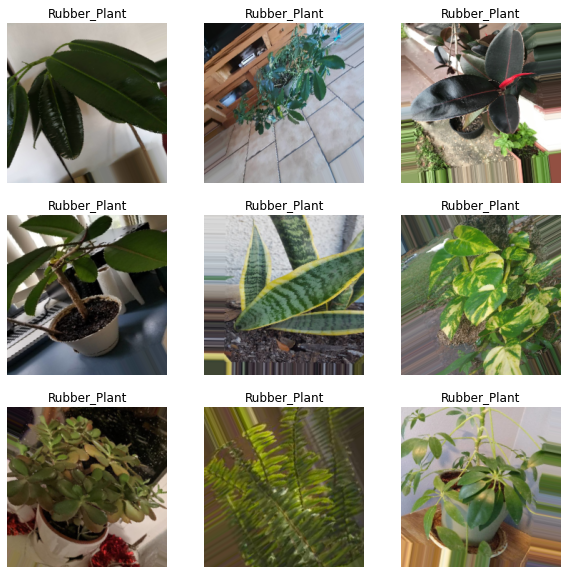

In [38]:
plt.figure(figsize=(10, 10))
images, labels = next(train_generator)

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[0])])
    plt.axis("off")

In [ ]:
# # 80% training set
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     data_path,
#     validation_split=0.2,
#     subset="training",
#     seed=123,
#     image_size=(img_height, img_width),
#     batch_size=batch_size)

# # 20% validation set
# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     data_path,
#     validation_split=0.2,
#     subset="validation",
#     seed=123,
#     image_size=(img_height, img_width),
#     batch_size=batch_size)

**List classes**

In [ ]:
class_names = train_ds.class_names
no_classes = len(class_names)
print(class_names)

**Sanity check the shape of inputs**

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

**Define class weights for imbalanced data**

![Data Imbalance](../data/figures/number_imgs_per_class.png "Data Imbalance")

Using class_weights changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like optimizers. SGD, may fail. The optimizer used here, optimizers. Adam, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [ ]:
label_list = []
for images, labels in train_ds.take(-1):
    batch_labels = labels.numpy()
    label_list.append(batch_labels)
    
label_list = np.concatenate( label_list, axis=0 )

In [ ]:
class_weight_arr = class_weight.compute_class_weight('balanced',
                                                 np.unique(label_list),
                                                 label_list)

class_weight_dict = dict(zip(np.arange(no_classes), class_weight_arr)) #.astype(str)

### Visualize raw data

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Preprocess the data

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.3),
  ]
)

**Visualize**

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Prefetch the data

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Build model

**First try**

In [ ]:
def get_prelim():
    model = Sequential([
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                     input_shape=(img_height, img_width, 3)),
        layers.experimental.preprocessing.RandomRotation(0.2),
        layers.experimental.preprocessing.RandomZoom(0.3),
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(no_classes),
        layers.Activation('softmax')
    ])
    return model

def get_double_conv_1():
    model = keras.models.Sequential([
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                     input_shape=(img_height, img_width, 3)),
        layers.experimental.preprocessing.RandomRotation(0.2),
        layers.experimental.preprocessing.RandomZoom(0.3),
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(64, 7, activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.Conv2D(256, 3, activation='relu', padding='same'),
        layers.Conv2D(256, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(no_classes, activation='softmax')
    ])
    return model

def get_dropout_1():
    model = Sequential([
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                     input_shape=(img_height, img_width, 3)),
        layers.experimental.preprocessing.RandomRotation(0.2),
        layers.experimental.preprocessing.RandomZoom(0.3),
        layers.experimental.preprocessing.Rescaling(1./255),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(no_classes, activation='softmax')
    ])
    return model

def get_VGG16tl():
    resize_layer = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))

    # create the base model from the pre-trained model VGG16
    # note that, if using a Kaggle server, internet has to be turned on
    pretrained_model = VGG16(input_shape=(img_height, img_width, 3),
                                                         include_top=False,
                                                         weights='imagenet')

    # freeze the convolutional base
    pretrained_model.trainable = False

    model = tf.keras.Sequential([
#         layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
#                                                      input_shape=(img_height, img_width, 3)),
#         layers.experimental.preprocessing.RandomRotation(0.2),
#         layers.experimental.preprocessing.RandomZoom(0.3),
        resize_layer,
        pretrained_model,
        # GlobalAveragePooling2D(), # maybe make max (first) or not at all
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5), # try 0.5
        Dense(256, activation='relu'),
        Dense(no_classes, activation='softmax')])
    return model

def get_InceptionV3tl():
    resize_layer = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))

    # create the base model from the pre-trained model VGG16
    # note that, if using a Kaggle server, internet has to be turned on
    pretrained_model = InceptionV3(input_shape=(img_height, img_width, 3),
                                                         include_top=False,
                                                         weights='imagenet')

    # freeze the convolutional base
    pretrained_model.trainable = False

    model = tf.keras.Sequential([resize_layer,
                                 pretrained_model,
#                                  GlobalMaxPooling2D(),
                                 Flatten(),
                                 Dense(256, activation='relu'),
                                 Dropout(0.5),
                                 Dense(256, activation='relu'),
                                 Dense(no_classes, activation='softmax')])
    return model

def get_InceptionV3tl2():
    resize_layer = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))

    # create the base model from the pre-trained model VGG16
    # note that, if using a Kaggle server, internet has to be turned on
    pretrained_model = InceptionV3(input_shape=(img_height, img_width, 3),
                                                         include_top=False,
                                                         weights='imagenet')

    # freeze the convolutional base
    pretrained_model.trainable = False

    model = tf.keras.Sequential([resize_layer,
                                 pretrained_model,
#                                  GlobalMaxPooling2D(),
                                 Flatten(),
                                 Dense(1024, activation='relu'),
                                 Dropout(0.2),
                                 Dense(no_classes, activation='softmax')])
    return model


def get_ResNet50tl():
    resize_layer = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))

    # create the base model from the pre-trained model VGG16
    # note that, if using a Kaggle server, internet has to be turned on
    pretrained_model = ResNet50(input_shape=(img_height, img_width, 3),
                                                         include_top=False,
                                                         weights='imagenet')

    # freeze the convolutional base
    pretrained_model.trainable = False

    model = tf.keras.Sequential([resize_layer,
                                 pretrained_model,
#                                  GlobalAveragePooling2D(),
                                 Flatten(),
                                 Dense(256, activation='relu'),
                                 Dropout(0.5),
                                 Dense(256, activation='relu'),
                                 Dense(no_classes, activation='softmax')])
    return model

def get_InceptionResNetV2tl():
    resize_layer = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))

    # create the base model from the pre-trained model VGG16
    # note that, if using a Kaggle server, internet has to be turned on
    pretrained_model = InceptionResNetV2(input_shape=(img_height, img_width, 3),
                                                         include_top=False,
                                                         weights='imagenet')

    # freeze the convolutional base
    pretrained_model.trainable = False

    model = tf.keras.Sequential([resize_layer,
                                 pretrained_model,
#                                  GlobalAveragePooling2D(),
                                 Flatten(),
                                 Dense(256, activation='relu'),
                                 Dropout(0.5),
                                 Dense(256, activation='relu'),
                                 Dense(no_classes, activation='softmax')])
    return model

def generate_model(model_name):
    
    if model_name == 'prelim':
        model = get_prelim()
        data_augmentation
    
    elif model_name == 'double_conv_1':
        model = get_double_conv_1()
    
    elif model_name == 'dropout_1':
        model = get_dropout_1()
    
    elif model_name == 'VGG16':
        model = get_VGG16tl()
    
    elif model_name == 'ResNet50':
        model = get_ResNet50tl()
    
    elif model_name == 'InceptionV3':
        model = get_InceptionV3tl()
    
    elif model_name == 'InceptionV3_1024':
        model = get_InceptionV3tl2()
  
    elif model_name == 'InceptionResNetV2':
        model = get_InceptionResNetV2tl()
    
    else:
        print('please select a valid model')
        
    
#     model = tf.keras.Sequential([
#         data_augmentation,
#         model
#     ])
    
    return model

In [ ]:
model = generate_model('InceptionV3_1024')

model.compile(loss = 'sparse_categorical_crossentropy',
            optimizer = 'adam',
            metrics = ['accuracy', 'sparse_top_k_categorical_accuracy'])

model.summary()

## Train model

In [ ]:
initial_epochs=40

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    class_weight=class_weight_dict)

In [ ]:
# unfreeze the layers
model.trainable = True

model.compile(loss = 'sparse_categorical_crossentropy',
            optimizer = keras.optimizers.Adam(1e-5),
            metrics = ['accuracy', 'sparse_top_k_categorical_accuracy'])

model.summary()

In [ ]:
fine_tune_epochs = 200
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1]+1,
                         validation_data=val_ds,
                         class_weight=class_weight_dict)

## Save model/metrics and plot

In [ ]:
model_name = 'InceptionV3_40_200e_GSP1.0'

In [ ]:
model.save_weights(f'../models/{model_name}_weights.h5')
model.save(f'../models/{model_name}_model.h5')

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

t5acc = history.history['sparse_top_k_categorical_accuracy']
t5val_acc = history.history['val_sparse_top_k_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

t5acc += history_fine.history['sparse_top_k_categorical_accuracy']
t5val_acc += history_fine.history['val_sparse_top_k_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)

x_plot = np.arange(1, total_epochs+1)

ax[0].plot(x_plot, acc[:total_epochs], '+-', label='training')
ax[0].plot(x_plot, val_acc[:total_epochs], '+-', label='validation')
ax[0].plot(x_plot, t5acc[:total_epochs], '+-', label='top 5 training')
ax[0].plot(x_plot, t5val_acc[:total_epochs], '+-', label='top 5 validation')
ax[0].legend()
ax[0].set_ylabel('accuracy')
# ax[0].set_ylim(0.5, 1)
ax[0].grid(ls='--', c='C7')
ax[0].set_title('accuracy')
ax[0].axvline(initial_epochs, c='C7', ls='--')

ax[1].plot(x_plot, loss[:total_epochs], '+-', label='training')
ax[1].plot(x_plot, val_loss[:total_epochs], '+-', label='validation')
ax[1].legend()
ax[1].set_ylabel('cross entropy')
# ax[1].set_ylim(0, 1)
ax[1].grid(ls='--', c='C7')
ax[1].set_title('loss')
ax[1].set_xlabel('epoch')
ax[1].axvline(initial_epochs, c='C7', ls='--')

plt.show()

plt.savefig(f'../models/{model_name}_graph.svg')
plt.savefig(f'../models/{model_name}_graph.png', dpi=400)

In [ ]:
graph_vals = pd.DataFrame({'acc':acc[:total_epochs],
                           'val_acc':val_acc[:total_epochs],
                           'loss':loss[:total_epochs],
                           'val_loss':val_loss[:total_epochs],
                           't5':t5acc[:total_epochs],
                           'val_t5':t5val_acc[:total_epochs]})

graph_vals.to_csv(f'../models/{model_name}_metrics.csv', index=False)

In [ ]:
val_predictions = model.predict(val_ds, batch_size=BATCH_SIZE)

In [ ]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")r4t
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [ ]:
plt.savefig('../models/VGG16_70e_1.0.svg')

In [ ]:
model.save_weights('../models/VGG16_20_100e_1.0.h5')
model.save('../models/VGG16_20_100e_1.0.h5')

In [ ]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [ ]:
# Use the model to predict the values from the validation dataset.
test_pred_raw = model.predict(val_ds)
test_pred = np.argmax(test_pred_raw, axis=1)

# Calculate the confusion matrix.
cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
# Log the confusion matrix as an image summary.
figure = plot_confusion_matrix(cm, class_names=class_names)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)

x_vals = np.arange(1, epochs+1)

ax[0].plot(x_vals, acc, '+-', label='training')
ax[0].plot(x_vals, val_acc, '+-', label='validation')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_ylim(0, 1)
ax[0].grid(ls='--', c='C7')
ax[0].set_title('accuracy')

ax[1].plot(x_vals, loss, '+-', label='training')
ax[1].plot(x_vals, val_loss, '+-', label='validation')
ax[1].legend()
ax[1].set_ylabel('cross entropy')
ax[1].set_ylim(0, 3)
ax[1].grid(ls='--', c='C7')
ax[1].set_title('loss')
ax[1].set_xlabel('epoch')

plt.show()

In [ ]:
model.save_weights('../models/.h5')
model.save('../models/.h5')

# Evaluation

In [ ]:
import glob

pred_path = '../data/pred_16c_only1/'

pred_ds = tf.keras.preprocessing.image_dataset_from_directory(
    pred_path,
#     labels = [0]*len(glob.glob(f'{pred_path}*')),
    image_size=(img_height, img_width),
    batch_size=batch_size
    )

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
predictions = model.predict(pred_ds)
print(predictions)

In [ ]:
# Generate arg maxes for predictions
classes = np.argmax(predictions, axis = 1)
print(classes[0])
print(class_names[classes[0]])

In [ ]:
temp = tf.keras.models.load_model('../models/convmod_1.0.h5')

In [ ]:
temp.summary()

In [ ]:
dot_img_file = '../models/convmod_1.0.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)